# Packet Analysis Using Data Science

***

![alt-text](https://www.metageek.com/inc/images/products/eyepa/eye-p.a.-chart-packet-capture-analysis.png)

## Getting Started

***

The first thing we are going to do in order to make all this possible, is downloading and importing a few libraries. These include:
+ [**Scapy**](https://scapy.net)- For packet manupilation.
+ [**Pandas**](https://pandas.pydata.org/) - To help us create and manupilate dataframes.
+ [**Numpy**](http://www.numpy.org/) - To help us perform complex mathematical functions.
+ [**Binascii**](https://docs.python.org/2/library/binascii.html) - To help us convert from Binary to Ascii.
+ [**Seaborn**](https://seaborn.pydata.org/) - For some awesome visualization. 

We are also going to add the Matplotlib inline (`%matplotlib inline`) function, to allow any visualization to appear within the notebook itself. 

So let's start by installing scapy into the notebook. 

In [70]:
!pip install scapy

Requirement not upgraded as not directly required: scapy in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages


In [71]:
%matplotlib inline

from scapy.all import *
import pandas as pd
import numpy as np
import binascii
import seaborn as sns

sns.set(color_codes=True)

## Sniffing packets in Scapy

***

Scapy is a tool that provides powerfull and interactive packet manupilation. it allows you to forge or decode packets of a wide number of protocols, send them on wire, capture them, match requests and replies, etc. Packet capture and analysis can primarily be accomplished using Wireshark, however, it is hard to keep track of multiple suspicious indicators while also keeping track of multiple connections in Wireshark. Manupliating packets in Scapy can get a little rigid, so we transform our packet capture into a Panda DataFrame. 



In [72]:
# num_of_packets_to_sniff = 100
# pcap = sniff(count=num_of_packets_to_sniff)

# print(type(pcap))
# print(len(pcap))
# print(pcap)
# pcap[0]

In [73]:
# The code was removed by Watson Studio for sharing.

In [74]:
# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about your possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_2 = client_c7eec7d7b64149299a9a6a4f16bf2179.get_object(Bucket='wiresharkpacketanalysis-donotdelete-pr-qh01rwgwwdwujj', Key='suspicious.pcap')['Body']
# add missing __iter__ method so pandas accepts body as file-like object
if not hasattr(streaming_body_2, "__iter__"): streaming_body_2.__iter__ = types.MethodType( __iter__, streaming_body_2 ) 
    
# pcap_test = rdpcap(streaming_body_2)
pcap = rdpcap(streaming_body_2)

# print(type(pcap_test))
# print(len(pcap_test))
# print(pcap_test)
# print(pcap_test[0])

# pcap_test.show()

In [75]:
# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about your possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_3 = client_c7eec7d7b64149299a9a6a4f16bf2179.get_object(Bucket='wiresharkpacketanalysis-donotdelete-pr-qh01rwgwwdwujj', Key='find the image.pcap')['Body']
# add missing __iter__ method so pandas accepts body as file-like object
if not hasattr(streaming_body_3, "__iter__"): streaming_body_3.__iter__ = types.MethodType( __iter__, streaming_body_3 ) 

pcap = rdpcap(streaming_body_3)

In [76]:
# Retrieving a single item from the packet list

ethernet_frame = pcap[0]
ip_packet = ethernet_frame.payload
segment = ip_packet.payload
data = segment.payload

print("ethernet_frame : ", ethernet_frame.show(), "\n\n")
print("ip_packet : ", ip_packet.show(), "\n\n")
print("segment : ", segment.show() ,"\n\n")
print("data : ", data.show() ,"\n\n") # If blank, empty object

ethernet_frame.show()

###[ Ethernet ]### 
  dst       = 64:66:b3:6f:e3:45
  src       = 60:36:dd:1e:9a:10
  type      = 0x800
###[ IP ]### 
     version   = 4
     ihl       = 5
     tos       = 0x0
     len       = 52
     id        = 18353
     flags     = DF
     frag      = 0
     ttl       = 128
     proto     = tcp
     chksum    = 0x2f58
     src       = 192.168.1.6
     dst       = 192.168.1.100
     \options   \
###[ TCP ]### 
        sport     = 65198
        dport     = mmcc
        seq       = 1290154816
        ack       = 0
        dataofs   = 8
        reserved  = 0
        flags     = S
        window    = 8192
        chksum    = 0x38c6
        urgptr    = 0
        options   = [('MSS', 1460), ('NOP', None), ('WScale', 8), ('NOP', None), ('NOP', None), ('SAckOK', b'')]

ethernet_frame :  None 


###[ IP ]### 
  version   = 4
  ihl       = 5
  tos       = 0x0
  len       = 52
  id        = 18353
  flags     = DF
  frag      = 0
  ttl       = 128
  proto     = tcp
  chksum    = 0x2f58
  src  

## Converting the PCAP frames to DataFrames

***

Next, we will try converting the PCAP frames to a Panda Dataframe. This will allow us to manupilate the data obtained from the packets with greater ease and efficiency. In order to do this, we will first obtain all the headers from the different layers of the packet frame (IP, TCP, UDP). Once we have the headers we create an empty panda data frame with those headers, and then populate it row by row, by inserting the frame array for each row. 

In [77]:
#Collect the field names from IP/TCP/UDP (These will be the columns in the DataFrame)

ip_fields =[field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

# print("ip_fields : ", ip_fields)
# print("tcp_fields : ", tcp_fields)
# print("udp_fields : ", udp_fields)

dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload', 'payload_raw', 'payload_hex']

# print("Dataframe_fields : ", dataframe_fields)

# Create a blank DataFrame.
df = pd.DataFrame(columns = dataframe_fields)

for packet in pcap[IP]:
    #Field array for each row of DataFrame
    field_values = []
    # Add all field values
    for field in ip_fields:
        if field == 'options':
            # Retrieving the number of options defined in IP headers
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
#             print(packet[IP].fields[field]) 
            
    field_values.append(packet.time)
#     print("Packet Time : ", packet.time) 
    
    layer_type = type(packet[IP].payload)
#     print("Layer Type : ", layer_type)   
    
    
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
            
    # Append payload
    field_values.append(len(packet[layer_type].payload))
    
    field_values.append(packet[layer_type].payload.original)
#     print("packet[layer_type].payload.original : ",  packet[layer_type].payload.original)
    
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
#     print("binascii.hexlify(packet[layer_type].payload.original) : ", binascii.hexlify(packet[layer_type].payload.original))
    
    # Add row to DF
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index()
# Drop old index column
df = df.drop(columns="index")
        
        

In [78]:
# The code was removed by Watson Studio for sharing.

## DataFrame Basics 

***

In [79]:
# Retrieve first row from DataFrame
print(df.iloc[0])

version                    4
ihl                        5
tos                        0
len                       52
id                     18353
flags                     DF
frag                       0
ttl                      128
proto                      6
chksum                 12120
src              192.168.1.6
dst            192.168.1.100
options                    0
time             1.39263e+09
sport                  65198
dport                   5050
seq               1290154816
ack                        0
dataofs                    8
reserved                   0
flags                      S
window                  8192
chksum                 14534
urgptr                     0
options                    6
payload                    0
payload_raw              b''
payload_hex              b''
Name: 0, dtype: object


In [80]:
# Shape of the dataframe
print("The shape of the dataframe is : ", df.shape)

The shape of the dataframe is :  (3641, 28)


In [81]:
# Return first 5 rows
df.head()

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
0,4,5,0,52,18353,DF,0,128,6,12120,...,8,0,S,8192,14534,0,6,0,b'',b''
1,4,5,0,40,21746,DF,0,128,6,8739,...,5,0,RA,0,39301,0,None,0,b'',b''
2,4,5,0,52,18354,DF,0,128,6,12119,...,8,0,S,8192,14534,0,6,0,b'',b''
3,4,5,0,40,21747,DF,0,128,6,8738,...,5,0,RA,0,39301,0,None,0,b'',b''
4,4,5,0,48,18355,DF,0,128,6,12122,...,7,0,S,8192,19669,0,4,0,b'',b''


In [82]:
# Return last 5 rows
df.tail()

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
3636,4,5,0,40,21850,DF,0,128,6,8635,...,5,0,A,176,15519,0,None,0,b'',b''
3637,4,5,0,40,21851,DF,0,128,6,8634,...,5,0,A,176,13371,0,None,0,b'',b''
3638,4,5,0,40,21852,DF,0,128,6,8633,...,5,0,A,193,10658,0,None,0,b'',b''
3639,4,5,0,40,21853,DF,0,128,6,8632,...,5,0,A,199,9914,0,None,0,b'',b''
3640,4,5,0,40,21854,DF,0,128,6,8631,...,5,0,RA,0,10109,0,None,0,b'',b''


In [83]:
df.to_csv("packet.csv")

## PCAP Statistics

***

One of the advantages of converting our PCAP packet frames to a Pandas DataFrame is that, now we can perform statistics on it. One of the most cumbersome aspects of Wireshark is that there is tons and tons of data, which makes it very hard to make any real insights from it, efficiently. With the help of Pandas we can perform some simple statistics, like seeing the most frequently used source address, or the most frequent destination address or port.



In [84]:
# Top Source Adddress
print("[*] Top Source Address: \n", df['src'].describe(), "\n\n")

# Top Destination Address
print("[*] Top Destination Address: \n ", df['dst'].describe(), "\n\n")

frequent_address = df['src'].describe()['top']
print("Frequent Address : ", frequent_address, "\n\n")

# Who is the top address speaking to
print("[*] Who is Top Address Speaking to?: \n ", df[df['src'] == frequent_address]['dst'].unique(), "\n\n")

# Who is the top address speaking to (dst ports)
print("[*] Who is the top address speaking to (Destination Ports): \n ", df[df['src'] == frequent_address]['dport'].unique(), "\n\n")

[*] Top Source Address: 
 count            3641
unique              5
top       192.168.1.6
freq             1555
Name: src, dtype: object 


[*] Top Destination Address: 
  count            3641
unique              5
top       192.168.1.6
freq             2086
Name: dst, dtype: object 


Frequent Address :  192.168.1.6 


[*] Who is Top Address Speaking to?: 
  ['192.168.1.100' '173.194.39.63' '173.194.34.41' '173.194.34.46'] 


[*] Who is the top address speaking to (Destination Ports): 
  [5050 443 7070] 




## Visualizations

***

Now that we have the statistics, the next step is to visualize the data. Visualization helps you identify most frequent addresses and ports much quicker and efficiently, and also identify anomolous activity in a glance. 


src
173.194.34.41    AxesSubplot(0.125,0.125;0.775x0.755)
173.194.34.46    AxesSubplot(0.125,0.125;0.775x0.755)
173.194.39.63    AxesSubplot(0.125,0.125;0.775x0.755)
192.168.1.100    AxesSubplot(0.125,0.125;0.775x0.755)
192.168.1.6      AxesSubplot(0.125,0.125;0.775x0.755)
Name: payload, dtype: object

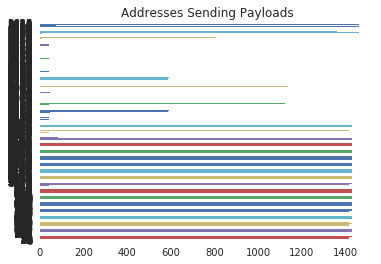

In [92]:
# Group by Source Address and Payload Sum
source_addresses = df.groupby("src")['payload']
source_addresses.plot(kind='barh',title="Addresses Sending Payloads")

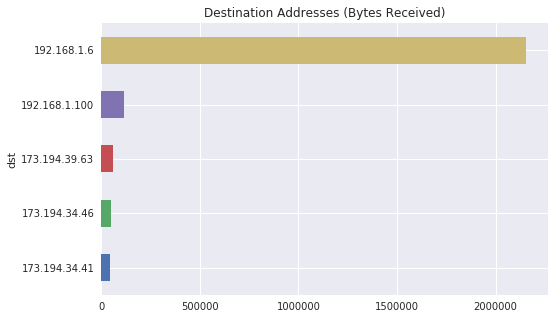

In [86]:
# Group by Destination Address and Payload Sum
destination_addresses = df.groupby("dst")['payload'].sum()
destination_addresses.plot(kind='barh', title="Destination Addresses (Bytes Received)",figsize=(8,5))

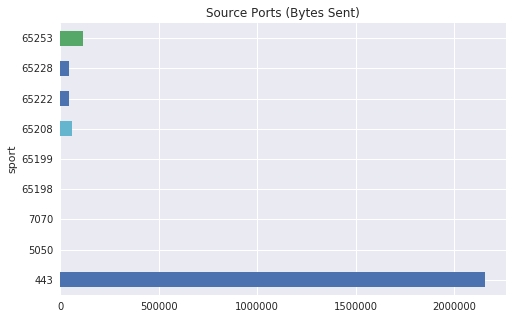

In [87]:
# Group by Source Port and Payload Sum
source_payloads = df.groupby("sport")['payload'].sum()
source_payloads.plot(kind='barh',title="Source Ports (Bytes Sent)",figsize=(8,5))

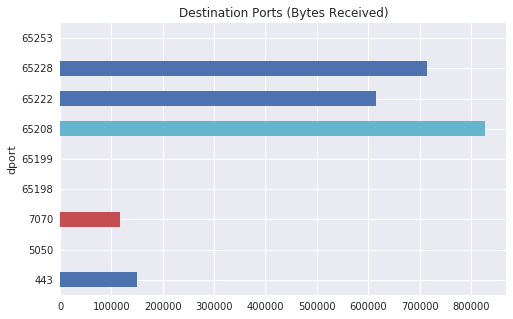

In [88]:
# Group by Destination Port and Payload Sum
destination_payloads = df.groupby("dport")['payload'].sum()
destination_payloads.plot(kind='barh',title="Destination Ports (Bytes Received)",figsize=(8,5))

## Payload Investigation

***

The graphs that we created highlighted the fact that a large amount of data was sent over port 53. Exfiltrating data using this port is a common technique for attackers due to the fact that restricting DNS communication can be troublesome. At this point, we can open wireshark or write a few lines of code to make this action repeatable. We’ll perform another grouping operation, separate the conversation into its own dataframe, and view the suspicious conversation:



192.168.1.100 May be a suspicious address
[b'', b'', b'', b'', b'', b'Hey bro\n', b'', b'yeah, u got the files?\n', b'', b'', b'ok we can use cryptcat\n', b'ok what the password then\n', b'', b'hhh, ok\n', b'listen on 7070 and ill send you the file , bye\n', b'', b'', b'', b'', b'\xff\xb8o\xa6k+\xc0\\\xe4i#\xf2\x88!8\xaa', b'\xba\xdf)\x86>\'\x83s\xaf\x87\xf9\x7f\x03\xb3\xc0\x04\xac\t\x98\xd92#0\xab\x1bI\xf9\xe3\x01\xbf-\xf2:R\xcaP_\xb0\xf2\xfe\x8dF\r2\x0cg\xa6\x93\x82.o\x0b\x10\xeda]\x0c_\x91\xd9\xa3\xed\x9dCa\xc0\xc59\xb3|e\x14\xaa\x86:\xe9[\x1e\xd6k\xee\x7f\x82\xe8\xdb\xb5\x1a\xf73\xa5\xdate\x05G\xa9nK\x96LdR\xd088\xe7\\\xc8\x84\xef%T[\x91#\xb1A\xc7\x82<\xe9\xc1\xe2\xe5\xd9\xd0\xe1\x15\xfc\x9b\xb4G\x15\x8b\x1dj\xcf\xd1~\xa4\xd0\x7f\xda\xf8\x8f\xccA\x97\xcf\xca\xfc\xb4\x84\x92\x85\xd1=\xcb\xa8N\xb6-\xea\xbb\xf5\xf6\xd1A\xd1\x0c\x1f\xfcRZuz]\x9b\xbd\xe2Ne\x8b!|\x88kg\x1c[\x97\x17\xee\xf6\x9b\xcb\xd9\xc9\xf0\x8b\xae(.\x1d\x17\x92\x1c\xef\x95\xc2D\xb8c\xc1\xa6FP^\xe5\x0f\x87V\x88^\xc8\x8

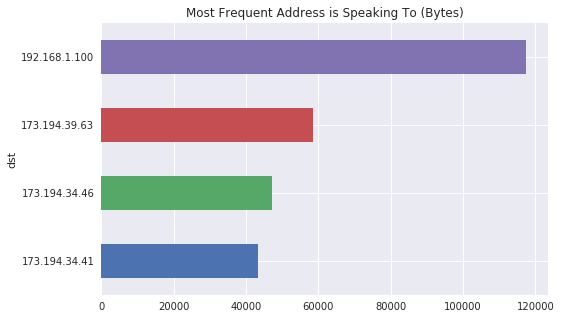

In [89]:
# Create dataframe with only converation from most frequent address
frequent_address_df = df[df['src']==frequent_address]

# Only display Src Address, Dst Address, and group by Payload 
frequent_address_groupby = frequent_address_df[['src','dst','payload']].groupby("dst")['payload'].sum()

# Plot the Frequent address is speaking to (By Payload)
frequent_address_groupby.plot(kind='barh',title="Most Frequent Address is Speaking To (Bytes)",figsize=(8,5))

# Which address has excahnged the most amount of bytes with most frequent address
suspicious_ip = frequent_address_groupby.sort_values(ascending=False).index[0]
print(suspicious_ip, "May be a suspicious address")

# Create dataframe with only conversation from most frequent address and suspicious address
suspicious_df = frequent_address_df[frequent_address_df['dst']==suspicious_ip]

# Store each payload in an array
raw_stream = []
for p in suspicious_df['payload_raw']:
    raw_stream.append(p)
    
print(raw_stream)

***